In [8]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
from interaction_inference import simulation
from interaction_inference.constraints import Constraint
from interaction_inference.optimization import Optimization

In [31]:
rng = np.random.default_rng(3)

# Downsamled optimization: Independent models

Due to binomial downsampling with the same capture efficiencies for each gene, the downsampled counts are positively correlated. So even if the original counts are sampled from a model with independent genes, the downsampled counts are not independent.

This means that for an independent model e.g. independent birth-death, we cannot use the 'marginal downsampled CME' as this would be assuming the downsampled counts are also independent (but are in fact positively correlated) and must use the 'joint downsampled CME' with the joint downsampled distribution (i.e. interacting birth-death model constraints with $k_{reg} = 0$):

$$
\begin{align}
0 =& k_{tx_1} p_{D} (x_1 - 1, x_2) \\
+& k_{tx_2} p_{D} (x_1, x_2 - 1) \\
+& k_{deg_1} (x_1 + 1) p_{D} (x_1 + 1, x_2) \\
+& k_{deg_2} (x_2 + 1) p_{D} (x_1, x_2 + 1) \\
-& (k_{tx_1} + k_{tx_2} + k_{deg_1} x_1 + k_{deg_2} x_2) p_{D} (x_1, x_2)
\end{align}
$$

Had mistakenly used 'marginal downsampled CME' in optimization test, so now investigate changes when fixing.


## Plan

- simulate independent & interacting birth-death data to check new downsampled 'independent' model constraints work
- vary interaction strength and capture efficiency (gridtest?) to measure performance, compare to performance of old (wrong) constraints
- investigate difference between new and old constraints (exteme cases?)
- test X1X2X3, X1X2X3X4 cases to see if detecting interaction between specific genes, or just in general

## Fixed constraints

Simulate interacting data and use both the old (marginal downsampled CME) and new (joint downsampled CME) constraints to optimize.

See that the results are fairly similar, although vary quite a bit run by run due to random sampling 

In [112]:
# simulate sample
data = simulation.simulate_dataset_range_BD(
    name = "test",
    interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0], #[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0],
    cells = 1000,
    rate = 1,
    tqdm_disable = False
)

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [113]:
# downsample
m = 0.9
b = (1 / m) - 1
beta = rng.beta(1, b, size=1000)
data = data.downsample("test", beta)

In [114]:
# bootstrap
data.compute_moments(tqdm_disable=False)
data.bootstrap_probabilities(tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

100%|██████████| 10/10 [00:00<00:00, 24.62it/s]


In [115]:
# construct constraints
constraints = Constraint(
    downsampled_probability = True,
    downsampled_CME         = True,
    k_deg_1                 = True,
    k_reg                   = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: OPTIMAL
Runtime: 0.020000219345092773
Optimization status: INFEASIBLE
Runtime: 0.020999908447265625
Optimization status: INFEASIBLE
Runtime: 0.6299998760223389
Optimization status: OPTIMAL
Runtime: 0.003999948501586914
Optimization status: INFEASIBLE
Runtime: 0.2389998435974121
Optimization status: INFEASIBLE
Runtime: 0.01699995994567871
Optimization status: OPTIMAL
Runtime: 0.016000032424926758
Optimization status: OPTIMAL
Runtime: 0.009999990463256836
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.015000104904174805


In [116]:
# construct old constraints
constraints = Constraint(
    downsampled_marginal_probability_1 = True,
    downsampled_marginal_probability_2 = True,
    downsampled_marginal_CME_1         = True,
    downsampled_marginal_CME_2         = True,
    k_deg_2                            = True,
    k_deg_1                            = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.002000093460083008
Optimization status: INFEASIBLE
Runtime: 0.04400014877319336
Optimization status: OPTIMAL
Runtime: 0.009999990463256836
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.01100015640258789
Optimization status: OPTIMAL
Runtime: 0.012000083923339844
Optimization status: OPTIMAL
Runtime: 0.014000177383422852
Optimization status: OPTIMAL
Runtime: 0.014999866485595703
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.009999990463256836


## Gridtest

To get a clearer picture of the difference in results for the two constraint sets, optimize multiple times over a grid of parameter settings: mean capture efficiency and interaction strength:

In [96]:
def gridtest(mean_capture_values, interaction_values, runs, rate, cells=1000):

    # result arrays
    result_array_new = np.zeros((len(mean_capture_values), len(interaction_values)))
    result_array_old = np.zeros((len(mean_capture_values), len(interaction_values)))

    # simulate sample
    data = simulation.simulate_dataset_range_BD(
        name = "gridtest",
        interaction_values = interaction_values * runs,
        cells = cells,
        rate = rate,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        print(f"{i + 1} / {len(mean_capture_values)}")

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsamped = data.downsample("gridtest_downsampled", beta)

        # bootstrap
        data_downsamped.bootstrap_probabilities(tqdm_disable=True)
        data_downsamped.compute_fm(tqdm_disable=True)

        # new constraints
        new_constraints = Constraint(
            downsampled_probability = True,
            downsampled_CME         = True,
            k_deg_1                 = True,
            k_reg                   = True
        )
        
        # old constraints
        old_constraints = Constraint(
            downsampled_marginal_probability_1 = True,
            downsampled_marginal_probability_2 = True,
            downsampled_marginal_CME_1         = True,
            downsampled_marginal_CME_2         = True,
            k_deg_2                            = True,
            k_deg_1                            = True
        )

        # optimize
        opt_new = Optimization(data_downsamped, new_constraints, tqdm_disable=True, print_solution=False)
        opt_old = Optimization(data_downsamped, old_constraints, tqdm_disable=True, print_solution=False)

        # store results
        for j, solution in opt_new.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_new[i, j % runs] += 1 / runs

        for j, solution in opt_old.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_old[i, j % runs] += 1 / runs

    return result_array_new, result_array_old

In [97]:
def plot_gridtest(result_array_new, result_array_old, mean_capture_values, interaction_values):

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    #plt.tight_layout()

    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

    vmin, vmax = 0, 1

    # new
    img_new = axs[0].imshow(result_array_new, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("Interaction strength")
    axs[0].set_xticks(range(len(interaction_values)))
    axs[0].set_xticklabels(interaction_values)
    axs[0].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[0].set_yticks(range(len(mean_capture_values)))
    axs[0].set_yticklabels(mean_capture_values)
    axs[0].set_title("Downsampled (fixed)")

    # old
    img_old = axs[1].imshow(result_array_old, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("Interaction strength")
    axs[1].set_xticks(range(len(interaction_values)))
    axs[1].set_xticklabels(interaction_values)
    axs[1].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[1].set_yticks(range(len(mean_capture_values)))
    axs[1].set_yticklabels(mean_capture_values)
    axs[1].set_title("Downsampled (wrong)")

    fig.suptitle("Downsampled Birth-death model infeasibility % across range of parameters")

    cbar = plt.colorbar(img_new, ax=axs)
    cbar.set_label("Infeasibility %")

### High expression

In [ ]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 3

# parameters
rate = 5
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest(mean_capture_values, interaction_values, runs, rate)

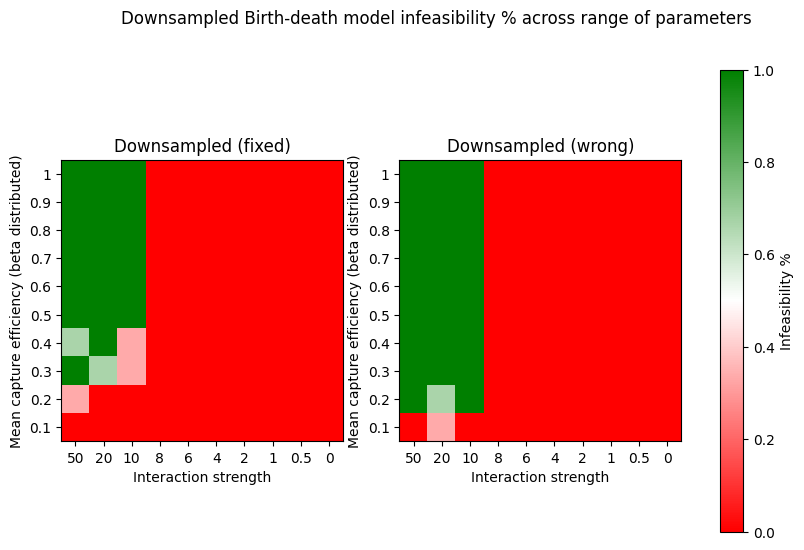

In [63]:
# plot
plot_gridtest(result_array_new, result_array_old, mean_capture_values, interaction_values)

### Low expression

In [117]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 5

# parameters
rate = 1
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest(mean_capture_values, interaction_values, runs, rate)

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


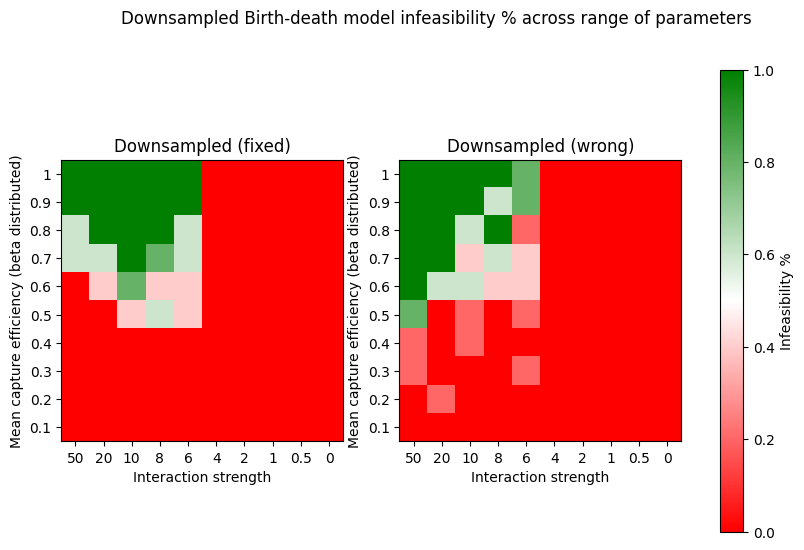

In [118]:
# plot
plot_gridtest(result_array_new, result_array_old, mean_capture_values, interaction_values)

There is still a large amount of random variation in the results, but overall see similar results for the two constraint sets with the old (wrong) constraints being infeasible slightly more often for lower capture efficiencies.